## prediction on s2 images
tested on a 8 core 30GB mem GCP VM (n1-standard8)

#### view training logs at
[https://wandb.ai/glennwithtwons/overstory/runs/idy2b028?workspace=user-glennwithtwons](https://wandb.ai/glennwithtwons/overstory/runs/idy2b028?workspace=user-glennwithtwons)

In [ ]:
import yaml
from pytorch_lightning import Trainer, seed_everything
import segmentation_models_pytorch as smp
import torch
import rioxarray as riox
import xarray as xr
import xbatcher
import matplotlib.pyplot as plt
%matplotlib inline

from src.litsegmodel import LitSegModel

#params are stored in config.yaml
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
seed_everything(1234)

ENCODER_NAME=config['ENCODER_NAME'] 
N_BAND=config['N_BAND']                  
N_CLASS=config['N_CLASS']

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8)
client = Client(cluster)
cluster.dashboard_link

'http://127.0.0.1:8787/status'

In [3]:
umodel = smp.Unet(
    encoder_name=ENCODER_NAME,
    in_channels=N_BAND,
    classes=N_CLASS,
)

model = LitSegModel(umodel)
trainer = Trainer()

checkpoint = 'checkpoints/epoch=4-step=2155.ckpt'
model = LitSegModel.load_from_checkpoint(checkpoint, model=umodel)


/opt/conda/envs/fsdl-text-recognizer-2022/lib/python3.7/site-packages/lightning_lite/accelerators/cuda.py:159: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## load an image to make predictions on

In [20]:
#load test image
test_ras = riox.open_rasterio('data/tif/Sentinel2L2A_sen2cor_30TXR_20190618_clouds=1.7%_area=100%.tif')
test_ras = test_ras.chunk({'x': 512, 'y': 512,'band':1})
minmax = xr.open_zarr('data/minmax.zarr')
#scale and drop bad band
#TODO: use quantile to scale
test_ras = (test_ras - minmax['min'])/(minmax['max']-minmax['min'])
test_ras = test_ras.where(test_ras.band<11,drop=True)
test_ras = test_ras.to_dataset(name='reflectance')

# load the cloud image
cloud_ras = riox.open_rasterio(
    'data/clouds/cloud_mask_30TXR_20190618_clouds=35%.tif')
cloud_ras = cloud_ras.to_dataset(name='label').where(cloud_ras>0,drop=False).squeeze()
cloud_ras = cloud_ras.chunk({'x': 512, 'y': 512})

#merge
test_ras = test_ras.merge(cloud_ras)
test_ras

<xarray.Dataset>
Dimensions:      (band: 10, x: 10980, y: 10980)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.1e+06 5.1e+06 5.1e+06 ... 4.99e+06 4.99e+06
    spatial_ref  int64 0
Data variables:
    reflectance  (band, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    label        (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>

In [21]:
#split into chips
batch_gen_test = xbatcher.BatchGenerator(
    test_ras,
    input_dims={"x": 2560, "y": 2560, "band": 10},
    concat_input_dims=False,
    preload_batch=False,
    )

#check output
for batch in batch_gen_test:
    print(batch)
    break

<xarray.Dataset>
Dimensions:      (band: 10, x: 2560, y: 2560)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 6e+05 6e+05 6e+05 ... 6.256e+05 6.256e+05 6.256e+05
  * y            (y) float64 5.1e+06 5.1e+06 5.1e+06 ... 5.074e+06 5.074e+06
    spatial_ref  int64 0
Data variables:
    reflectance  (band, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    label        (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>


In [26]:
#make prediction on each chip
def plot_batch(batch):
    #turn the data into tensor
    pr = torch.tensor(batch['reflectance'].load().data).unsqueeze(0)
    #predict
    y = model.predict(pr).squeeze()
    #convert to xarray with coords
    da = xr.DataArray(
        y,
        coords=batch['label'].coords,
        dims=batch['label'].dims
    )
    # combine plots into single figure
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    batch['label'].plot(ax=ax[0],cmap='tab20b')
    ax[0].set_title('label')
    da.plot(ax=ax[1])
    ax[1].set_title('prediction')
    batch['reflectance'][[2,1,0],:,:].plot.imshow(rgb='band', robust=True, ax=ax[2])
    ax[2].set_title('rgb')
    return

In [27]:
#plot generator
plot_gen = (plot_batch(batch) for batch in batch_gen_test)

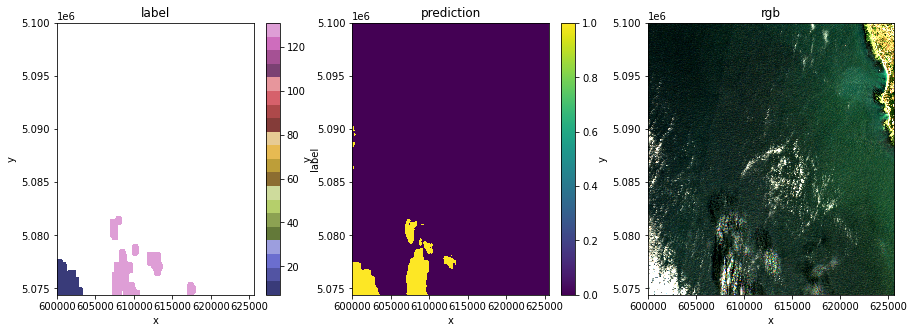

In [28]:
next(iter(plot_gen))

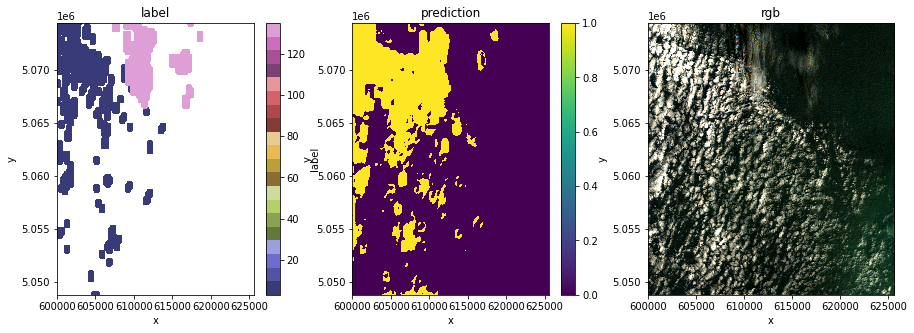

In [31]:
next(iter(plot_gen))

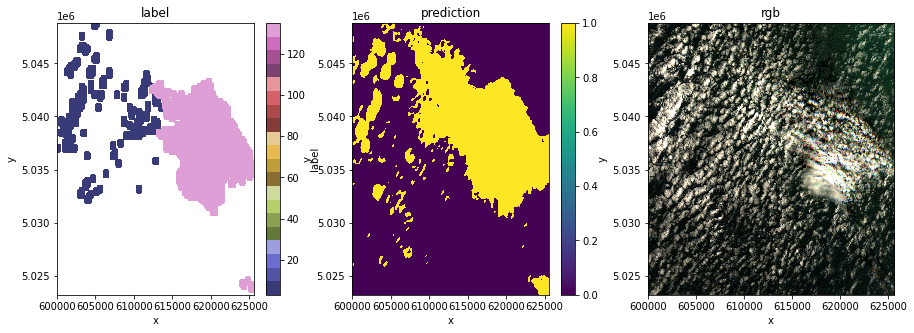

In [32]:
next(iter(plot_gen))

### predict on all batches, combine and export tif

In [30]:
#make prediction on each chip
def get_batch(batch):
    #turn the data into tensor
    pr = torch.tensor(batch['reflectance'].load().data).unsqueeze(0)
    #predict
    y = model.predict(pr).squeeze()
    #convert to xarray with coords
    da = xr.DataArray(
        y,
        coords=batch['label'].coords,
        dims=batch['label'].dims
    )
    return da

#iterate and combine
pbatch = [get_batch(batch) for batch in batch_gen_test]
pall = xr.combine_by_coords(pbatch)

#save to tiff using rioxarray
pall.rio.to_raster('data/prediction_label.tif',dtype='int8')